In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
 
import seaborn as sns
import re
import nltk
import pickle

from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
# function to make n-grams
from nltk.util import ngrams 
from nltk import everygrams
from keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(vocabulary = myvocabulary, stop_words = 'english')
# tfs = tfidf.fit_transform(corpus.values())

from keras import layers
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.corpora import Dictionary
import itertools
from collections import defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline
import mysql.connector



Using TensorFlow backend.


In [2]:
# increasing max length for all columns and number of columns
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_columns", 50)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# functions for tokenizing, word count and wordcloud
tknz = TweetTokenizer()



def tokenize_tweet(s):
    """
    Tokenize each text into a list of words removing the ashtags
    """
    tokens = tknz.tokenize(s)
    return [w for w in tokens]

def tokenize_ngrams(s, ngram):
    """
    Tokenize each text into a list of words removing the ashtags in n-grams
    """
    tokens =  ngrams(s, ngram)
    return [w for w in tokens]
    


def get_tokens_frequency_df(series):
    """
    Count each time the same word appeared in the series
    :return: dataFrame
    """
    corpus_lists = [doc for doc in series.dropna() if doc]
    dictionary = Dictionary(corpus_lists)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]
    token_freq_bow = defaultdict(int)
    for token_id, token_sum in itertools.chain.from_iterable(corpus_bow):
        token_freq_bow[token_id] += token_sum

    return pd.DataFrame(list(token_freq_bow.items()), columns=['token_id', 'token_count']).assign(
        token=lambda df1: df1.apply(lambda df2: dictionary.get(df2.token_id), axis=1),
        doc_appeared=lambda df1: df1.apply(lambda df2: dictionary.dfs[df2.token_id], axis=1)).reindex(
        labels=['token_id', 'token', 'token_count', 'doc_appeared'], axis=1).set_index('token_id')


def plot_word_cloud(df, top_n):
    word_cloud = WordCloud(background_color='white', colormap='magma', contour_width=1,
                           contour_color='orange', relative_scaling=0.5)

    sorted_freq_dict = dict(df[['token', 'token_count']].nlargest(top_n, columns='token_count').values)
    wc = word_cloud.generate_from_frequencies(frequencies=sorted_freq_dict, max_font_size=40)

    _, ax = plt.subplots(figsize=(15, 8))
    ax.set_title('Term Frequency', fontsize=16)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')

    

In [4]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="password",
    database="twitter_2",
    charset = 'utf8'
 )


In [5]:
# check that it's connected
mycursor = db.cursor()
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)
    

('twitter_2',)


In [6]:
time_now = datetime.now()
time_now.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-18 10:30:00'

In [7]:
time_10mins_before = timedelta(hours=0,minutes=300)
time_10mins_before

datetime.timedelta(seconds=18000)

In [8]:
time_interval = time_now - time_10mins_before
time_interval.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-18 05:30:00'

In [9]:
# load data in the last 1 hour
query = "SELECT id_str, created_at, text, processed FROM twitter_2 WHERE created_at >= '{}'"     \
        .format(time_interval)

df = pd.read_sql(query, con=db)

In [10]:
# UTC for date time at default
df['created_at'] = pd.to_datetime(df['created_at'])

In [11]:
df

,id_str,created_at,text,processed
0,1262314163717705728,2020-05-18 09:28:43,@PeterObi gives road map to economic recovery post #COVID19 #coronavirus @julietkego @iSERVE2050 @Umu_Igbo https://t.co/mG2uivMcmQ,-1
1,1262314166422958081,2020-05-18 09:28:44,RT @SheenaParish: WHO offered me 20million dollars to put a little toxic in my Covid-19 remedy Madagascar President exposes WHO Obrem,-1
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true? I hope so! #LockHimUp #BillGatesIsEvil,-1
3,1262314173700112387,2020-05-18 09:28:46,RT @JEPaquetEU: The EU is organizing a global pledging event to help finance a #coronavirus vaccine. We aim to raise 7.5 billion in init,-1
4,1262314176019599363,2020-05-18 09:28:46,"RT @RealJamesWoods: #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes, slaughtering thousan",-1
5,1262314176325746689,2020-05-18 09:28:46,"@RedwingUK1978 @piersmorgan #coronavirus isn't political, it's a global pandemic that needs a united world to sol https://t.co/38wuahJ2Jb",-1
6,1262314176418062338,2020-05-18 09:28:46,RT @21WIRE: You can see how deep the #BillGates/#Fauci agenda has penetrated the states now. Here's one dissenting voice from #Minnesota...,-1
7,1262314176816361472,2020-05-18 09:28:47,Assassin's Creed Syndicate \n@Ubisoft @assassinscreed\n\n#VGPUnite\n#VirtualPhotography\n#AssassinsCreedSyndicate https://t.co/K9vTlXgPgt,-1
8,1262314179261693953,2020-05-18 09:28:47,RT @IndoPac_Info: Almost 120 nations have now backed an international push for a coronavirus inquiry: #Australian H. Minister Greg Hunt \n\nE,-1
9,1262314179496566784,2020-05-18 09:28:47,RT @aus_business: #coronavirus retail changes mean Cotton On has had about half its 300 new jobs go to existing staff redeployed from the c,-1


In [12]:
def clean_text(string):
    """Function makes the text columns similar 
       to preprocessing used for training model"""
    #removes retweets with http     
    new_str = re.sub(r"http://t(?!$)", '', string)
    #removes retweets with https
    new_str = re.sub(r"https?://[A-Za-z0-9./]*", '',new_str)
    #removes ashtags followed by numbers     
    new_str = re.sub(r"#[0-9]", '', new_str)
    # removes handles     
    new_str = re.sub(r"@[\w]*", '', new_str)
    new_str = re.sub(r"[^a-zA-Z'#]", ' ', new_str)
    return new_str

In [13]:
df['text'] = df['text'].apply(clean_text)

In [14]:
# also getting rid of all words shorter than 3 characters
df['tweet_more_2_charac'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

In [15]:
df

,id_str,created_at,text,processed,tweet_more_2_charac
0,1262314163717705728,2020-05-18 09:28:43,gives road map to economic recovery post #COVID #coronavirus,-1,gives road map economic recovery post #COVID #coronavirus
1,1262314166422958081,2020-05-18 09:28:44,RT WHO offered me million dollars to put a little toxic in my Covid remedy Madagascar President exposes WHO Obrem,-1,WHO offered million dollars put little toxic Covid remedy Madagascar President exposes WHO Obrem
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true I hope so #LockHimUp #BillGatesIsEvil,-1,know this true hope #LockHimUp #BillGatesIsEvil
3,1262314173700112387,2020-05-18 09:28:46,RT The EU is organizing a global pledging event to help finance a #coronavirus vaccine We aim to raise billion in init,-1,The organizing global pledging event help finance #coronavirus vaccine aim raise billion init
4,1262314176019599363,2020-05-18 09:28:46,RT #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,-1,#KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan
5,1262314176325746689,2020-05-18 09:28:46,#coronavirus isn't political it's a global pandemic that needs a united world to sol,-1,#coronavirus isn't political it's global pandemic that needs united world sol
6,1262314176418062338,2020-05-18 09:28:46,RT You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota,-1,You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota
7,1262314176816361472,2020-05-18 09:28:47,Assassin's Creed Syndicate #VGPUnite #VirtualPhotography #AssassinsCreedSyndicate,-1,Assassin's Creed Syndicate #VGPUnite #VirtualPhotography #AssassinsCreedSyndicate
8,1262314179261693953,2020-05-18 09:28:47,RT Almost nations have now backed an international push for a coronavirus inquiry #Australian H Minister Greg Hunt E,-1,Almost nations have now backed international push for coronavirus inquiry #Australian Minister Greg Hunt
9,1262314179496566784,2020-05-18 09:28:47,RT #coronavirus retail changes mean Cotton On has had about half its new jobs go to existing staff redeployed from the c,-1,#coronavirus retail changes mean Cotton has had about half its new jobs existing staff redeployed from the



# Lemmatization with POS

In [16]:
# defining different POS
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# function to lemmatize all words in a sentence
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
            # 'ass' kept being reduced to 'as' for some reason         
        if word == 'ass':
            lemmatized_sentence.append(word)
        
        elif tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [17]:
df['lemmatized'] = df['tweet_more_2_charac'].apply(lambda x: lemmatize_sentence(x))

In [18]:
df

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized
0,1262314163717705728,2020-05-18 09:28:43,gives road map to economic recovery post #COVID #coronavirus,-1,gives road map economic recovery post #COVID #coronavirus,give road map economic recovery post # COVID # coronavirus
1,1262314166422958081,2020-05-18 09:28:44,RT WHO offered me million dollars to put a little toxic in my Covid remedy Madagascar President exposes WHO Obrem,-1,WHO offered million dollars put little toxic Covid remedy Madagascar President exposes WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true I hope so #LockHimUp #BillGatesIsEvil,-1,know this true hope #LockHimUp #BillGatesIsEvil,know this true hope # LockHimUp # BillGatesIsEvil
3,1262314173700112387,2020-05-18 09:28:46,RT The EU is organizing a global pledging event to help finance a #coronavirus vaccine We aim to raise billion in init,-1,The organizing global pledging event help finance #coronavirus vaccine aim raise billion init,The organize global pledging event help finance # coronavirus vaccine aim raise billion init
4,1262314176019599363,2020-05-18 09:28:46,RT #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,-1,#KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,# KillerCuomo and other Democrat vermin shoehorn infect # CoronaVirus carrier into nurse home slaughter thousan
5,1262314176325746689,2020-05-18 09:28:46,#coronavirus isn't political it's a global pandemic that needs a united world to sol,-1,#coronavirus isn't political it's global pandemic that needs united world sol,# coronavirus be n't political it 's global pandemic that need united world sol
6,1262314176418062338,2020-05-18 09:28:46,RT You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota,-1,You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota,You can see how deep the # BillGates # Fauci agenda have penetrate the state now Here 's one dissenting voice from # Minnesota
7,1262314176816361472,2020-05-18 09:28:47,Assassin's Creed Syndicate #VGPUnite #VirtualPhotography #AssassinsCreedSyndicate,-1,Assassin's Creed Syndicate #VGPUnite #VirtualPhotography #AssassinsCreedSyndicate,Assassin 's Creed Syndicate # VGPUnite # VirtualPhotography # AssassinsCreedSyndicate
8,1262314179261693953,2020-05-18 09:28:47,RT Almost nations have now backed an international push for a coronavirus inquiry #Australian H Minister Greg Hunt E,-1,Almost nations have now backed international push for coronavirus inquiry #Australian Minister Greg Hunt,Almost nation have now back international push for coronavirus inquiry # Australian Minister Greg Hunt
9,1262314179496566784,2020-05-18 09:28:47,RT #coronavirus retail changes mean Cotton On has had about half its new jobs go to existing staff redeployed from the c,-1,#coronavirus retail changes mean Cotton has had about half its new jobs existing staff redeployed from the,# coronavirus retail change mean Cotton have have about half its new job exist staff redeploy from the


In [19]:
# getting rid of the ashtags
df['lemmatized_no_ash'] = df['lemmatized'].str.replace('# ', '')

In [20]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash
0,1262314163717705728,2020-05-18 09:28:43,gives road map to economic recovery post #COVID #coronavirus,-1,gives road map economic recovery post #COVID #coronavirus,give road map economic recovery post # COVID # coronavirus,give road map economic recovery post COVID coronavirus
1,1262314166422958081,2020-05-18 09:28:44,RT WHO offered me million dollars to put a little toxic in my Covid remedy Madagascar President exposes WHO Obrem,-1,WHO offered million dollars put little toxic Covid remedy Madagascar President exposes WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true I hope so #LockHimUp #BillGatesIsEvil,-1,know this true hope #LockHimUp #BillGatesIsEvil,know this true hope # LockHimUp # BillGatesIsEvil,know this true hope LockHimUp BillGatesIsEvil
3,1262314173700112387,2020-05-18 09:28:46,RT The EU is organizing a global pledging event to help finance a #coronavirus vaccine We aim to raise billion in init,-1,The organizing global pledging event help finance #coronavirus vaccine aim raise billion init,The organize global pledging event help finance # coronavirus vaccine aim raise billion init,The organize global pledging event help finance coronavirus vaccine aim raise billion init
4,1262314176019599363,2020-05-18 09:28:46,RT #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,-1,#KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,# KillerCuomo and other Democrat vermin shoehorn infect # CoronaVirus carrier into nurse home slaughter thousan,KillerCuomo and other Democrat vermin shoehorn infect CoronaVirus carrier into nurse home slaughter thousan


Removing StopWords

In [21]:
# importing english stopwords
stop = stopwords.words('english')

df['tweet_low'] = df['lemmatized_no_ash'].apply(lambda x: x if type(x)!=str else x.lower())
df['tweet_without_stopwords'] = df['tweet_low'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))







In [22]:
df

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords
0,1262314163717705728,2020-05-18 09:28:43,gives road map to economic recovery post #COVID #coronavirus,-1,gives road map economic recovery post #COVID #coronavirus,give road map economic recovery post # COVID # coronavirus,give road map economic recovery post COVID coronavirus,give road map economic recovery post covid coronavirus,give road map economic recovery post covid coronavirus
1,1262314166422958081,2020-05-18 09:28:44,RT WHO offered me million dollars to put a little toxic in my Covid remedy Madagascar President exposes WHO Obrem,-1,WHO offered million dollars put little toxic Covid remedy Madagascar President exposes WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem,who offer million dollar put little toxic covid remedy madagascar president expose who obrem,offer million dollar put little toxic covid remedy madagascar president expose obrem
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true I hope so #LockHimUp #BillGatesIsEvil,-1,know this true hope #LockHimUp #BillGatesIsEvil,know this true hope # LockHimUp # BillGatesIsEvil,know this true hope LockHimUp BillGatesIsEvil,know this true hope lockhimup billgatesisevil,know true hope lockhimup billgatesisevil
3,1262314173700112387,2020-05-18 09:28:46,RT The EU is organizing a global pledging event to help finance a #coronavirus vaccine We aim to raise billion in init,-1,The organizing global pledging event help finance #coronavirus vaccine aim raise billion init,The organize global pledging event help finance # coronavirus vaccine aim raise billion init,The organize global pledging event help finance coronavirus vaccine aim raise billion init,the organize global pledging event help finance coronavirus vaccine aim raise billion init,organize global pledging event help finance coronavirus vaccine aim raise billion init
4,1262314176019599363,2020-05-18 09:28:46,RT #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,-1,#KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,# KillerCuomo and other Democrat vermin shoehorn infect # CoronaVirus carrier into nurse home slaughter thousan,KillerCuomo and other Democrat vermin shoehorn infect CoronaVirus carrier into nurse home slaughter thousan,killercuomo and other democrat vermin shoehorn infect coronavirus carrier into nurse home slaughter thousan,killercuomo democrat vermin shoehorn infect coronavirus carrier nurse home slaughter thousan
5,1262314176325746689,2020-05-18 09:28:46,#coronavirus isn't political it's a global pandemic that needs a united world to sol,-1,#coronavirus isn't political it's global pandemic that needs united world sol,# coronavirus be n't political it 's global pandemic that need united world sol,coronavirus be n't political it 's global pandemic that need united world sol,coronavirus be n't political it 's global pandemic that need united world sol,coronavirus n't political 's global pandemic need united world sol
6,1262314176418062338,2020-05-18 09:28:46,RT You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota,-1,You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice from #Minnesota,You can see how deep the # BillGates # Fauci agenda have penetrate the state now Here 's one dissenting voice from # Minnesota,You can see how deep the BillGates Fauci agenda have penetrate the state now Here 's one dissenting voice from Minnesota,you can see how deep the billgates fauci agenda have penetrate the state now here 's one dissenting voice from minnesota,see deep billgates fauci agenda

# Vectorizing TF-IDF for Fresh Tweets for Logistic Regression

In [66]:
tf_idf_fit_only = pickle.load( open("tfidf_pickle_fit", "rb" ))

In [67]:
matrix =tf_idf_fit_only.transform(df['tweet_without_stopwords'])

In [68]:
# vectorising the new tweets
df_vector = pd.DataFrame(matrix.todense(),columns = tf_idf_fit_only.get_feature_names())

In [69]:
df_vector

,aap,aaron,abandon,abc,ability,able,abo,absolute,absolutely,absolutely love,abt,abundance,abuse,abusive,academy,acc,accent,accept,accept fact,acceptable,access,accessory,accident,accidentally,accord,...,youre,yous,youth,youtube,youtube video,youtuber,youuu,yoy,yrs,yum,yummy,yung,yup,yyc,zealand,zebra,zelda,zen,zero,zimmerman,zip,zoe,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# import pickled logistic regression

model_log = pickle.load( open("pickled_logistic_1", "rb" ))
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
y_hat_fresh =  model_log.predict_proba(df_vector)
predictions = y_hat_fresh[:,1]
predictions


array([0.08060906, 0.1591895 , 0.10391954, 0.05772063, 0.13639828,
       0.07345067, 0.14390854, 0.14249131, 0.15455569, 0.10194323,
       0.33253658, 0.09966863, 0.14580463, 0.13639828, 0.03846398,
       0.1035584 , 0.08327761, 0.1035584 , 0.06122343, 0.13639828,
       0.06369324, 0.13639828, 0.1035584 , 0.19120372, 0.04903145,
       0.17671199, 0.10601002, 0.10601002, 0.12684188, 0.12934552,
       0.17548385, 0.09485509, 0.04042807, 0.05976013, 0.10267543,
       0.10995015, 0.10736596, 0.1591895 , 0.09519649, 0.19760275,
       0.07338714, 0.06699977, 0.13359552, 0.15274224, 0.14468032,
       0.33253658, 0.20084599, 0.0542984 , 0.17548385, 0.05820502,
       0.06867366, 0.03021365, 0.18481917, 0.06712056, 0.13180609,
       0.04381282, 0.11862748, 0.06332271, 0.12699353, 0.1354883 ,
       0.03410894, 0.13359552, 0.09344933, 0.13639828, 0.09597868,
       0.15274224, 0.12716926, 0.17999287, 0.09795212, 0.07220367,
       0.10339771, 0.12106723, 0.06919871, 0.10882402, 0.07659

In [80]:
final_res =[]
for x in predictions:
    if x >.3:
        final_res.append(1)
    else:
        final_res.append(0)
final_res
len(final_res)



117

In [81]:
df['predictions'] = pd.Series(final_res)


In [84]:
df.head(50)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords,tokenized,predictions
0,1262314163717705728,2020-05-18 09:28:43,gives road map to economic recovery post #COVID #coronavirus,-1,gives road map economic recovery post #COVID #coronavirus,give road map economic recovery post # COVID # coronavirus,give road map economic recovery post COVID coronavirus,give road map economic recovery post covid coronavirus,give road map economic recovery post covid coronavirus,"[give, road, map, economic, recovery, post, covid, coronavirus]",0
1,1262314166422958081,2020-05-18 09:28:44,RT WHO offered me million dollars to put a little toxic in my Covid remedy Madagascar President exposes WHO Obrem,-1,WHO offered million dollars put little toxic Covid remedy Madagascar President exposes WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem,WHO offer million dollar put little toxic Covid remedy Madagascar President expose WHO Obrem,who offer million dollar put little toxic covid remedy madagascar president expose who obrem,offer million dollar put little toxic covid remedy madagascar president expose obrem,"[offer, million, dollar, put, little, toxic, covid, remedy, madagascar, president, expose, obrem]",0
2,1262314166423031809,2020-05-18 09:28:44,Do we know if this is true I hope so #LockHimUp #BillGatesIsEvil,-1,know this true hope #LockHimUp #BillGatesIsEvil,know this true hope # LockHimUp # BillGatesIsEvil,know this true hope LockHimUp BillGatesIsEvil,know this true hope lockhimup billgatesisevil,know true hope lockhimup billgatesisevil,"[know, true, hope, lockhimup, billgatesisevil]",0
3,1262314173700112387,2020-05-18 09:28:46,RT The EU is organizing a global pledging event to help finance a #coronavirus vaccine We aim to raise billion in init,-1,The organizing global pledging event help finance #coronavirus vaccine aim raise billion init,The organize global pledging event help finance # coronavirus vaccine aim raise billion init,The organize global pledging event help finance coronavirus vaccine aim raise billion init,the organize global pledging event help finance coronavirus vaccine aim raise billion init,organize global pledging event help finance coronavirus vaccine aim raise billion init,"[organize, global, pledging, event, help, finance, coronavirus, vaccine, aim, raise, billion, init]",0
4,1262314176019599363,2020-05-18 09:28:46,RT #KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,-1,#KillerCuomo and other Democrat vermin shoehorn infected #CoronaVirus carriers into nursing homes slaughtering thousan,# KillerCuomo and other Democrat vermin shoehorn infect # CoronaVirus carrier into nurse home slaughter thousan,KillerCuomo and other Democrat vermin shoehorn infect CoronaVirus carrier into nurse home slaughter thousan,killercuomo and other democrat vermin shoehorn infect coronavirus carrier into nurse home slaughter thousan,killercuomo democrat vermin shoehorn infect coronavirus carrier nurse home slaughter thousan,"[killercuomo, democrat, vermin, shoehorn, infect, coronavirus, carrier, nurse, home, slaughter, thousan]",0
5,1262314176325746689,2020-05-18 09:28:46,#coronavirus isn't political it's a global pandemic that needs a united world to sol,-1,#coronavirus isn't political it's global pandemic that needs united world sol,# coronavirus be n't political it 's global pandemic that need united world sol,coronavirus be n't political it 's global pandemic that need united world sol,coronavirus be n't political it 's global pandemic that need united world sol,coronavirus n't political 's global pandemic need united world sol,"[coronavirus, n't, political, ', s, global, pandemic, need, united, world, sol]",0
6,1262314176418062338,2020-05-18 09:28:46,RT You can see how deep the #BillGates #Fauci agenda has penetrated the states now Here's one dissenting voice fro

# CNN for Fresh Tweets

In [85]:
# cnn = pickle.load( open("pickle_cnn", "rb" ) )

In [86]:
# df['tokenized'] = df['lemmatized_no_ash'].apply(tokenize_tweet)

In [87]:
# df

In [88]:
# # Some variables that will be used throughout the modeling process
# num_words = 20000 # The max number of words in our vocabulary
# epochs = 10  
# batch_size = 64  
# sequence_len = 200  # Maximum number of words in a sequence
# embedding_dimensions = 200  # Number of dimensions of the trainable embedding layer

In [89]:
# tk = Tokenizer(num_words=num_words, # The 20000 most important words for our vocabulary
#                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
#                lower=True, # Lowercase the text data for consistency
#                split=" ")
# tk.fit_on_texts(df['tokenized']) # Fit on our training set
# X_train_seq = tk.texts_to_sequences(df['tokenized']) # Indexed sequences based on fitted tokenizer


In [90]:
# X_train_seq_pad = pad_sequences(X_train_seq, maxlen=23) # Padding the sequences so that they are all the same length


In [91]:
# predictions = cnn.predict(X_train_seq_pad)[:,0]

In [92]:
# len(predictions)

In [93]:
# predictions

# Naive Bayes for Fresh Tweets

In [94]:
# cv = pickle.load(open("CVBayes", "rb" ))

In [95]:
# bayes = pickle.load(open("BayesModel", "rb" ))

In [96]:
# docs_new = df['lemmatized_no_ash']
# x_new_counts = cv.transform(docs_new).toarray()
# bayes.predict_proba(x_new_counts)

In [97]:
# x_new_counts.shape

# WordCloud, WordCount and Negative Tweets Highlight

In [98]:
# Clean and transform data to enable time series
result = df.groupby(                                        \
      [pd.Grouper(key='created_at', freq='2s'), 'predictions'] \
    ).count().unstack().stack().reset_index()

result = result.rename(columns=   \                          
    { "id_str": "Num of 'Coronavirus' mentions",  \
      "created_at": "Time in UTC" })

In [99]:
result


,Time in UTC,predictions,Num of 'Coronavirus' mentions,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords,tokenized
0,2020-05-18 09:28:42,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2020-05-18 09:28:44,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2020-05-18 09:28:46,0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
3,2020-05-18 09:28:48,0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
4,2020-05-18 09:28:48,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,2020-05-18 09:28:50,0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
6,2020-05-18 09:28:52,0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
7,2020-05-18 09:28:54,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8,2020-05-18 09:28:56,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
9,2020-05-18 09:28:58,0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [102]:
df['tokenized'] = df['tweet_without_stopwords'].apply(tokenize_tweet)

In [103]:
counts = get_tokens_frequency_df(df['tokenized'])
counts = counts.sort_values(by='token_count', ascending = False)
counts = counts[:10]


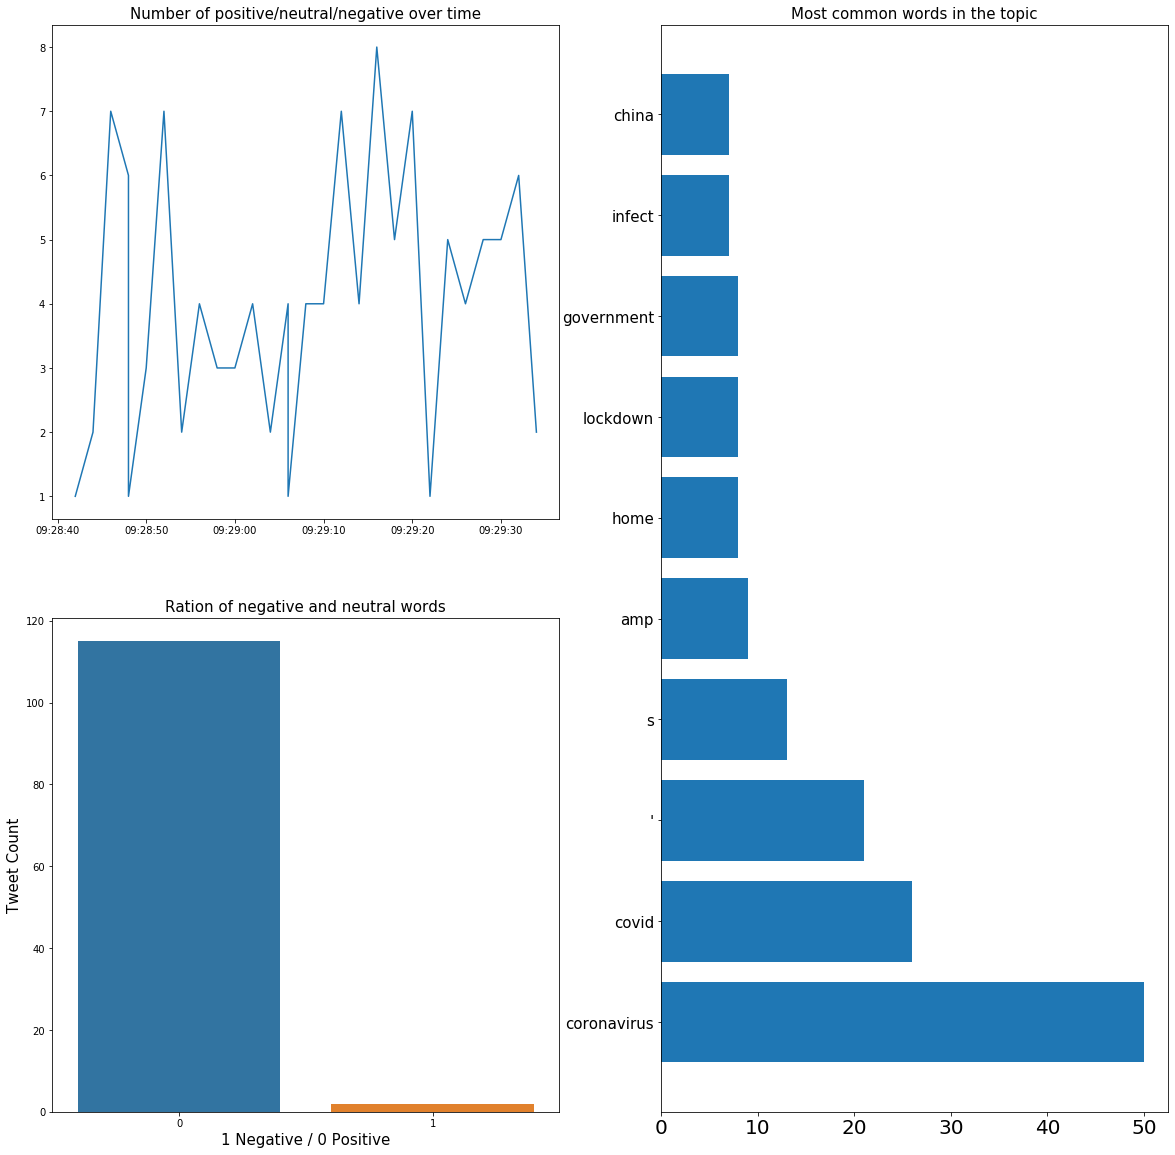

In [107]:
fig, axes = plt.subplots(2,2, figsize = (20,20))


ax1 = plt.subplot(221)
plt.title('Number of positive/neutral/negative over time', fontsize = 15)

ax1 = plt.plot(result['Time in UTC'], (result["Num of 'Coronavirus' mentions"]))
# ax1 = plt.plot(result['created_at'], (result['predictions']==1))

ax2 = plt.subplot(122)
plt.title('Most common words in the topic', fontsize = 15)
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 15)
ax2 = plt.barh(counts['token'], counts['token_count'])

ax3 = plt.subplot(223)
plt.title('Ration of negative and neutral words', fontsize = 15)
plt.xlabel('1 Negative / 0 Positive', fontsize = 15)
plt.ylabel('Tweet Count', fontsize = 15)
predictions = df['predictions'].value_counts()
sns.barplot(predictions.index, predictions.values)

plt.show()
